In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

warnings.filterwarnings('ignore')

In [2]:
def data_prep(MildDementia, ModerateDementia, VerymildDementia, NonDemented):

    MildDementia= ["imagesoasis/Data/Mild Dementia" + '/' +  MildDementia for MildDementia in MildDementia]
    ModerateDementia= ["imagesoasis/Data/Moderate Dementia"  + '/' +  ModerateDementia for ModerateDementia in ModerateDementia]
    VerymildDementia= ["imagesoasis/Data/Very mild Dementia"  + '/' +  VerymildDementia for VerymildDementia in VerymildDementia]
    NonDemented= ["imagesoasis/Data/Non Demented"  + '/' +  NonDemented for NonDemented in NonDemented]

    labels = len(MildDementia)*['MildDementia'] + len(ModerateDementia)*['ModerateDementia'] + len(VerymildDementia)*['VerymildDementia'] + len(NonDemented)*['NonDemented']
    data = MildDementia + ModerateDementia + VerymildDementia + NonDemented

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [3]:
df = data_prep(os.listdir('imagesoasis/Data/Mild Dementia'), os.listdir('imagesoasis/Data/Moderate Dementia'),
               os.listdir('imagesoasis/Data/Very mild Dementia'), os.listdir('imagesoasis/Data/Non Demented'))

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.sample(10)

,Image_Path,Labels
18642,imagesoasis/Data/Non Demented/OAS1_0221_MR1_mp...,NonDemented
30676,imagesoasis/Data/Non Demented/OAS1_0141_MR1_mp...,NonDemented
73597,imagesoasis/Data/Non Demented/OAS1_0002_MR1_mp...,NonDemented
50800,imagesoasis/Data/Non Demented/OAS1_0208_MR1_mp...,NonDemented
65458,imagesoasis/Data/Non Demented/OAS1_0190_MR1_mp...,NonDemented
23441,imagesoasis/Data/Non Demented/OAS1_0050_MR1_mp...,NonDemented
74266,imagesoasis/Data/Non Demented/OAS1_0200_MR1_mp...,NonDemented
49232,imagesoasis/Data/Non Demented/OAS1_0107_MR1_mp...,NonDemented
18033,imagesoasis/Data/Non Demented/OAS1_0148_MR1_mp...,NonDemented
16522,imagesoasis/Data/Non Demented/OAS1_0370_MR1_mp...,NonDemented


In [6]:
def plot_images(class_label, df, num_images=5):

    class_df = df[df['Labels'] == class_label].head(num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    for i, (img_path) in enumerate(class_df['Image_Path']):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_label} - Image {i+1}')

    plt.tight_layout()
    plt.show()

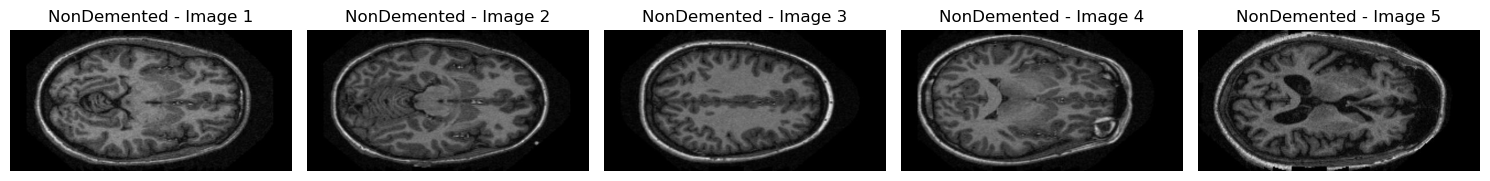

In [7]:
plot_images('NonDemented', df)

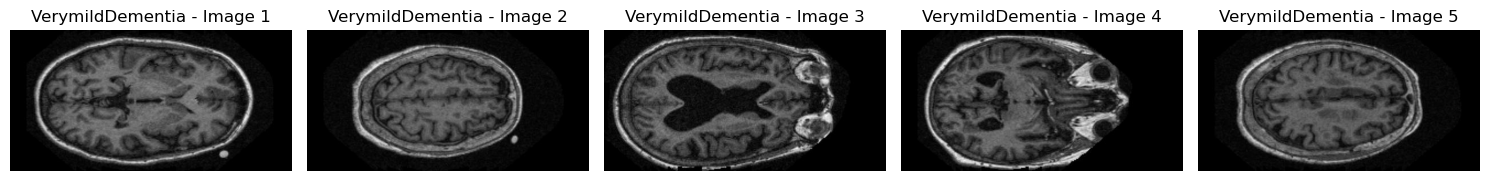

In [8]:
plot_images('VerymildDementia', df)

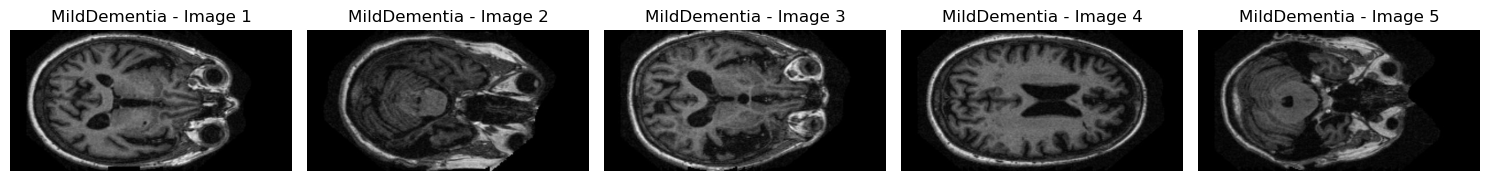

In [9]:
plot_images('MildDementia', df)

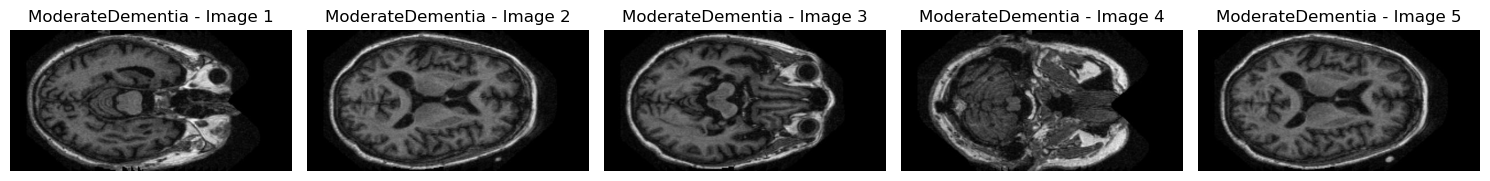

In [10]:
plot_images('ModerateDementia', df)

In [11]:
df.Labels.value_counts()

Labels
NonDemented         67222
VerymildDementia    13725
MildDementia         5002
ModerateDementia      488
Name: count, dtype: int64

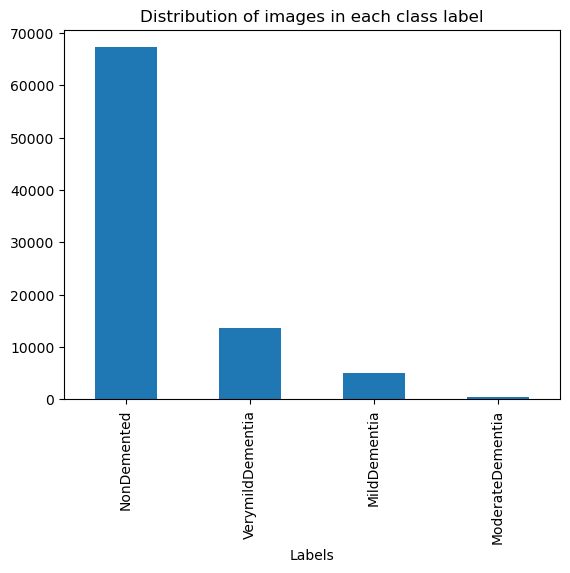

In [12]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label')
plt.show()

Data is imbalanced hence reducing the data size by using the sample images from majority classes

In [14]:
df = df.groupby('Labels').apply(lambda x: x.sample(n=5000, random_state=42) if x['Labels'].iloc[0] in ['NonDemented', 'VerymildDementia', 'MildDementia'] else x)
df = df.reset_index(drop=True)

In [15]:
df.Labels.value_counts()

Labels
MildDementia        5000
NonDemented         5000
VerymildDementia    5000
ModerateDementia     488
Name: count, dtype: int64

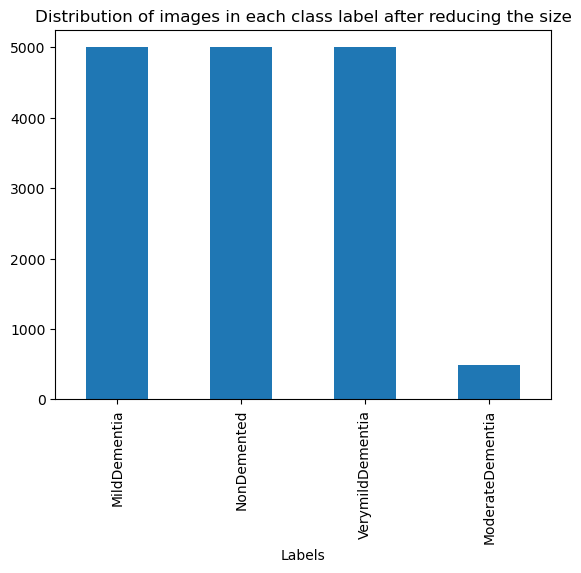

In [16]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label after reducing the size')
plt.show()

In [17]:
train, test = train_test_split(df, test_size = .30)

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,                    # Rescale pixel values to [0, 1]
)

In [19]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,                     # File paths are in the dataframe
    x_col='Image_Path',                 # Column with image file paths
    y_col='Labels',                     # Column with labels
    target_size=(224, 224),             # Resize images to 224x224 (or your desired size)
    batch_size=32,                      # Number of images to process in each batch
    class_mode='categorical',           # Classification task (one-hot encoding)
    shuffle=True                        # Shuffle the data
)

Found 10841 validated image filenames belonging to 4 classes.


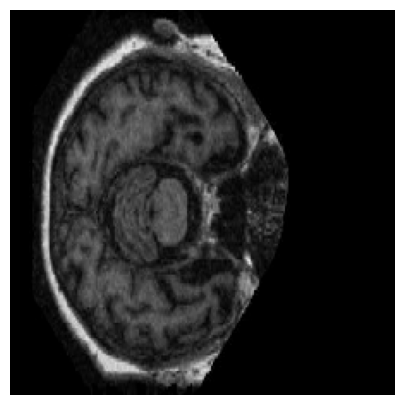

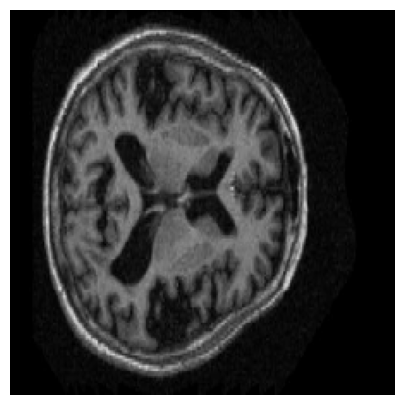

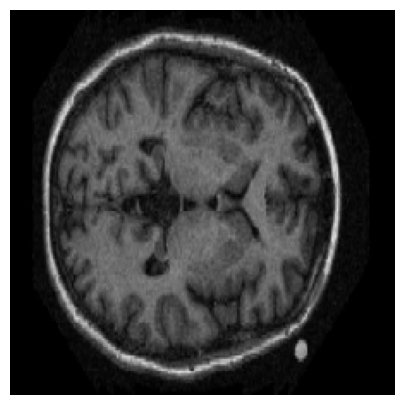

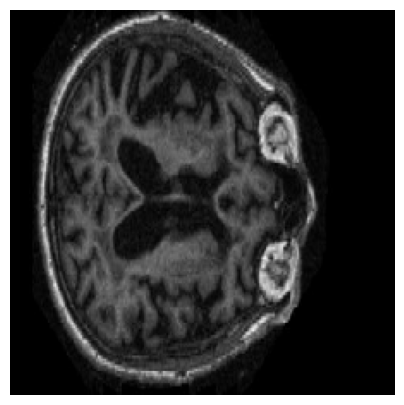

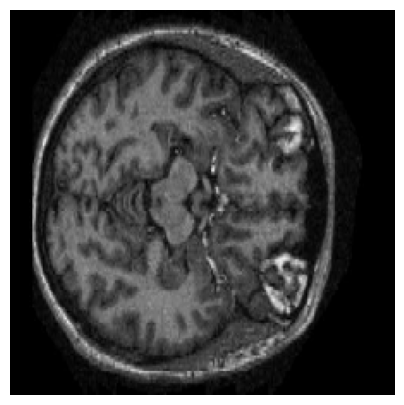

In [20]:
def augmented_images(generator, num_images=5):

    for i in range(num_images):
        img, label = next(generator)
        plt.figure(figsize=(5, 5))
        plt.imshow(img[0])
        plt.axis('off')
        plt.show()

augmented_images(train_generator, num_images=5)

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,                      # File paths are in the dataframe
    x_col='Image_Path',                   # Column with image file paths
    y_col='Labels',                       # Column with labels
    target_size=(224, 224),               # Resize images to 224x224 (or your desired size)
    batch_size=32,                        # Number of images to process in each batch
    class_mode='categorical',             # Classification task (one-hot encoding)
    shuffle=False                         # Do not shuffle test data
)

Found 4647 validated image filenames belonging to 4 classes.


In [23]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 312s 912ms/step - accuracy: 0.5126 - loss: 1.0336 - val_accuracy: 0.8900 - val_loss: 0.3130
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 288s 850ms/step - accuracy: 0.8706 - loss: 0.3307 - val_accuracy: 0.9522 - val_loss: 0.1410
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 286s 845ms/step - accuracy: 0.9269 - loss: 0.1806 - val_accuracy: 0.9647 - val_loss: 0.0950
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 319s 837ms/step - accuracy: 0.9519 - loss: 0.1238 - val_accuracy: 0.9763 - val_loss: 0.0644
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 286s 843ms/step - accuracy: 0.9648 - loss: 0.0897 - val_accuracy: 0.9776 - val_loss: 0.0608
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 290s 857ms/step - accuracy: 0.9689 - loss: 0.0878 - val_accuracy: 0.9886 - val_loss: 0.0384
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 292s 862ms/step - accuracy: 0.9774 - loss: 0.0622 - val_accuracy: 0.9828 - val_loss: 0.0508
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 292s 861ms/step - accuracy: 0.9793 -

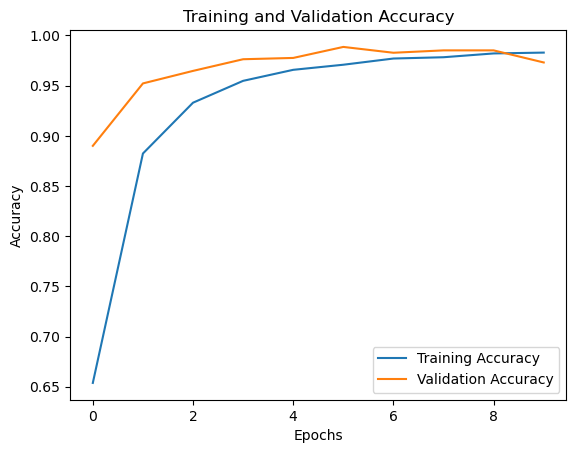

In [25]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

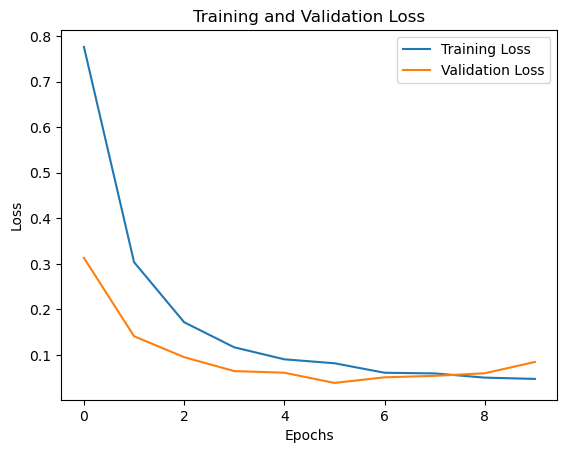

In [26]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
input_shape = (224, 224, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2339s 7s/step - accuracy: 0.3349 - loss: 1.6496 - val_accuracy: 0.3415 - val_loss: 1.1381
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2343s 7s/step - accuracy: 0.3834 - loss: 1.2013 - val_accuracy: 0.5933 - val_loss: 1.1032
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2368s 7s/step - accuracy: 0.4489 - loss: 1.1356 - val_accuracy: 0.6288 - val_loss: 1.0244
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2429s 7s/step - accuracy: 0.4762 - loss: 1.0819 - val_accuracy: 0.6415 - val_loss: 0.9478
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2723s 8s/step - accuracy: 0.4827 - loss: 1.0456 - val_accuracy: 0.6406 - val_loss: 0.8926
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3102s 9s/step - accuracy: 0.4901 - loss: 1.0260 - val_accuracy: 0.6447 - val_loss: 0.8546
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2891s 9s/step - accuracy: 0.4905 - loss: 1.0147 - val_accuracy: 0.6264 - val_loss: 0.8761
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 2417s 7s/step - accuracy: 0.4998 - loss: 0.9960 - 

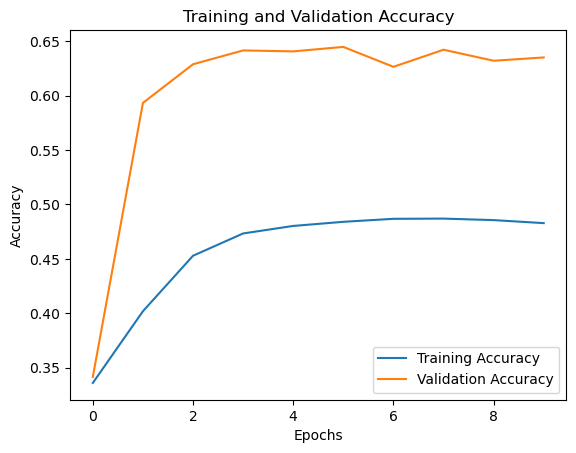

In [29]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

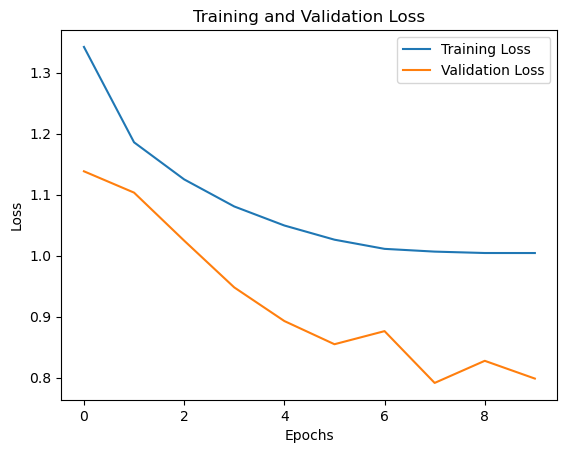

In [30]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()